# ***Renewable Energy Forecasting  🌱***

> This script is used to develop a predictive model for solar renewable energy production. The goal is to enhance forecasting accuracy and optimize energy resource management.

* ***Source: 🔗*** https://www.kaggle.com/datasets/henriupton/wind-solar-electricity-production

* ***Description:📝*** The dataset contains 59,806 records with key features like Date, Time, Source, and Production, capturing renewable energy production (solar and wind) in France.

* ***Purpose:*** This dataset enables the exploration and prediction of renewable energy output, focusing on production patterns across different energy sources.

## Import Necessary Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objs as go
import plotly.subplots as sp
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

# ***Data Preperation 🧹***

##  **Load and Prepare Data**



In [2]:
file_path = 'raw_data/intermittent-renewables-production-france.csv'
data = pd.read_csv(file_path)

### Rename the <code>***Date***</code> column to <code>***DateTime***</code>


In [3]:
data.rename(columns={'Date': 'DateTime'}, inplace=True)

### Convert <code>***DateTime***</code> column to *datetime* type


In [4]:
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
print(data['DateTime'].dtype)

datetime64[ns]


### Drop rows with missing values in key columns <code>[***DateTime*** , ***Production***]</code>


In [5]:
data['Production'] = data['Production'].fillna(data['Production'].mean())

### Sort data and filter for solar <code>***Production***</code> from *2020* to *2022*
> We are excluding data from 2023 because it only extends until June. Using incomplete data for the year could disrupt the detection of seasonal patterns, as the full annual cycle is not represented.

In [6]:
data_sorted = data.sort_values('DateTime').reset_index(drop=True)

## Filter data for solar production
data_wind = data[data['Source'] == 'Wind'][['DateTime', 'Production']].copy()
data_solar = data[data['Source'] == 'Solar'][['DateTime', 'Production']].copy()

## Ensure 'DateTime' is set as index for resampling
data_wind.set_index('DateTime', inplace=True)
data_solar.set_index('DateTime', inplace=True)

## Filter data_solar to include only data from 2020 to 2022
data_wind_filtered = data_wind[(data_wind.index >= '2020-01-01') & (data_wind.index < '2023-01-01')]
data_solar_filtered = data_solar[(data_solar.index >= '2020-01-01') & (data_solar.index < '2023-01-01')]


In [7]:
# Apply Simple Exponential Smoothing (SES) to smooth the time series for solar production
solar_model = SimpleExpSmoothing(data_solar_filtered['Production']).fit(smoothing_level=0.2, optimized=False)
data_solar_filtered.loc[:, 'Production'] = solar_model.fittedvalues

# Apply Simple Exponential Smoothing (SES) to smooth the time series for wind production
wind_model = SimpleExpSmoothing(data_wind_filtered['Production']).fit(smoothing_level=0.2, optimized=False)
data_wind_filtered.loc[:, 'Production'] = wind_model.fittedvalues

/Users/almuhannad/.pyenv/versions/3.10.6/envs/renewable_energy_forecasting/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almuhannad/.pyenv/versions/3.10.6/envs/renewable_energy_forecasting/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almuhannad/.pyenv/versions/3.10.6/envs/renewable_energy_forecasting/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almuhannad/.pyenv/versions/3.10.6/envs/renewable_energy_forecasting/lib/py

In [8]:
## Resample to daily totals after filtering
wind_daily = data_wind_filtered['Production'].resample('D').sum()
solar_daily = data_solar_filtered['Production'].resample('D').sum()

### Convert the <code>***solar_daily***</code> Series to a DataFrame.


In [9]:
wind_daily = wind_daily.to_frame(name='Wind_Production')
solar_daily = solar_daily.to_frame(name='Solar_Production')

In [10]:
wind_daily.head()

,Wind_Production
DateTime,
2020-01-01,78152.372131
2020-01-02,71216.087487
2020-01-03,106409.701277
2020-01-04,90467.060323
2020-01-05,78987.148402


In [11]:
solar_daily.head()

,Solar_Production
DateTime,
2020-01-01,11034.117084
2020-01-02,18070.004193
2020-01-03,14143.809403
2020-01-04,9372.566483
2020-01-05,17906.246286


## **Stationary Checking**

### **ADF test is a statistical test used to check if a time series is stationary or not.**

* **ADF Statistic:** which shows the level of stationarity. Lower values often indicate a more stationary series.


* **p-value:** which is used to determine if the series is stationary.


> dictionary of **critical values** at different confidence levels (1%, 5%, and 10%). These values give us reference points to compare with the ADF Statistic.


### *Wind Data*

In [12]:
adf_test = adfuller(wind_daily['Wind_Production'])
adf_stat = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

print(f'ADF Statistic: {adf_stat}')
print(f'p-value: {p_value}')
print('Critical Values:', critical_values)

print("--------------------------------------------------------------")
if p_value < 0.05:
    print("The time series is stationary (p < 0.05).")
else:
    print("The time series is non-stationary (p >= 0.05).")


ADF Statistic: -7.3679471536164085
p-value: 9.130864417555108e-11
Critical Values: {'1%': -3.436352507699052, '5%': -2.86419037625175, '10%': -2.56818114683546}
--------------------------------------------------------------
The time series is stationary (p < 0.05).


### *Solar Data*

In [13]:
adf_test = adfuller(solar_daily['Solar_Production'])
adf_stat = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

print(f'ADF Statistic: {adf_stat}')
print(f'p-value: {p_value}')
print('Critical Values:', critical_values)

print("--------------------------------------------------------------")
if p_value < 0.05:
    print("The time series is stationary (p < 0.05).")
else:
    print("The time series is non-stationary (p >= 0.05).")


ADF Statistic: -2.000122002198877
p-value: 0.2865196080179302
Critical Values: {'1%': -3.436396912213269, '5%': -2.864209963080287, '10%': -2.5681915787162484}
--------------------------------------------------------------
The time series is non-stationary (p >= 0.05).


In [14]:
# Apply differencing since the series is non-stationary
print("Applying first differencing to make the series stationary...")
solar_diff = solar_daily['Solar_Production'].diff().dropna()

# Re-run ADF Test on the differenced series
adf_test_diff = adfuller(solar_diff)
adf_stat_diff = adf_test_diff[0]
p_value_diff = adf_test_diff[1]
critical_values_diff = adf_test_diff[4]

# Print ADF test results for differenced data
print(f'\nADF Statistic (Differenced): {adf_stat_diff}')
print(f'p-value (Differenced): {p_value_diff}')
print('Critical Values (Differenced):', critical_values_diff)
print("--------------------------------------------------------------")

# Check if differenced series is now stationary
if p_value_diff < 0.05:
  print("The differenced time series is now stationary (p < 0.05).")
else:
    print("The differenced time series is still non-stationary (p >= 0.05).")

Applying first differencing to make the series stationary...

ADF Statistic (Differenced): -14.639811937612592
p-value (Differenced): 3.639088186146676e-27
Critical Values (Differenced): {'1%': -3.436396912213269, '5%': -2.864209963080287, '10%': -2.5681915787162484}
--------------------------------------------------------------
The differenced time series is now stationary (p < 0.05).


## **Seasonal Decomposition Analysis**


### *Wind Data*

In [15]:

result = seasonal_decompose(wind_daily['Wind_Production'], model='additive', period=365)

fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True,
                       subplot_titles=['Trend', 'Seasonal'])

fig.add_trace(go.Scatter(x=wind_daily.index, y=result.trend, mode='lines', name='Trend'), row=1, col=1)
fig.add_trace(go.Scatter(x=wind_daily.index, y=result.seasonal, mode='lines', name='Seasonal'), row=2, col=1)

fig.update_layout(template='plotly_dark', height=800, title='Seasonal Decomposition of Solar Production')
fig.show()

### *Solar Data*

In [16]:

result = seasonal_decompose(solar_daily['Solar_Production'], model='additive', period=365)

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True,
                       subplot_titles=['Trend', 'Seasonal'])

fig.add_trace(go.Scatter(x=solar_daily.index, y=result.trend, mode='lines', name='Trend'), row=1, col=1)
fig.add_trace(go.Scatter(x=solar_daily.index, y=result.seasonal, mode='lines', name='Seasonal'), row=2, col=1)

fig.update_layout(template='plotly_dark', height=800, title='Seasonal Decomposition of Solar Production')
fig.show()


# ***Model Choosing 🧠***

##  **Splitting the Data 🔪**

### Splitting <code>***Wind***</code> data into <code>[***Training***,***Testing***]</code>

In [17]:
tscv_solar = TimeSeriesSplit(n_splits=3, test_size=30, gap=2)
for train_index, test_index in tscv_solar.split(solar_daily):
    solar_train, solar_test = solar_daily.iloc[train_index], solar_daily.iloc[test_index]
    print(f"Training data length (Solar): {len(solar_train)}")
    print(f"Testing data length (Solar): {len(solar_test)}")

Training data length (Solar): 1004
Testing data length (Solar): 30
Training data length (Solar): 1034
Testing data length (Solar): 30
Training data length (Solar): 1064
Testing data length (Solar): 30


### Splitting <code>***Solar***</code> data into <code>[***Training***,***Testing***]</code>

In [18]:
tscv_wind = TimeSeriesSplit(n_splits=3, test_size=30, gap=2)
for train_index, test_index in tscv_wind.split(wind_daily):
    wind_train, wind_test = wind_daily.iloc[train_index], wind_daily.iloc[test_index]
    print(f"Training data length (Wind): {len(wind_train)}")
    print(f"Testing data length (Wind): {len(wind_test)}")

Training data length (Wind): 1004
Testing data length (Wind): 30
Training data length (Wind): 1034
Testing data length (Wind): 30
Training data length (Wind): 1064
Testing data length (Wind): 30


##  **Choose/Build/Train/Evaluation the Model 🛠️ 🏋️‍♂️ 📈**

### First Model: ***ARIMA Model***

#### ARIMA Model for <code>***Wind***</code>

##### Determine **ARIMA Wind Model** Parameters

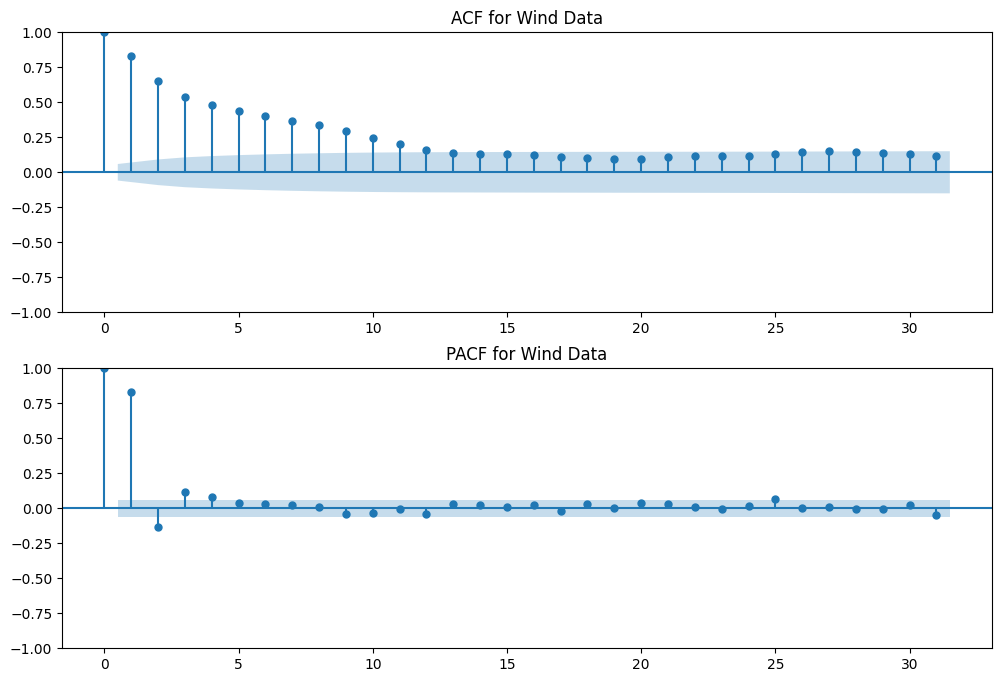

In [19]:
fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(wind_daily, ax=ax[0], title='ACF for Wind Data')
plot_pacf(wind_daily, ax=ax[1], title='PACF for Wind Data')
plt.show()

##### Construct / Fit the **ARIMA Wind Model**

In [20]:
model_wind = ARIMA(wind_train, order=(1, 0, 2))
wind_model_fit = model_wind.fit()

print(wind_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        Wind_Production   No. Observations:                 1064
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -12298.412
Date:                Wed, 16 Oct 2024   AIC                          24606.824
Time:                        21:47:29   BIC                          24631.673
Sample:                    01-01-2020   HQIC                         24616.240
                         - 11-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.951e+04   4952.745     20.092      0.000    8.98e+04    1.09e+05
ar.L1          0.8250      0.025     33.408      0.000       0.777       0.873
ma.L1          0.1480      0.038      3.927      0.0

##### Evaluate the **ARIMA Wind Model** on <code>Test</code> Data

In [21]:
wind_forecast = wind_model_fit.forecast(steps=len(wind_test))

rmse_wind = np.sqrt(mean_squared_error(wind_test, wind_forecast))
print(f'Wind Forecast RMSE: {rmse_wind}')

Wind Forecast RMSE: 98726.86995180353


#### ARIMA Model for <code>***Solar***</code>

##### Determine **ARIMA Solar Model** Parameters

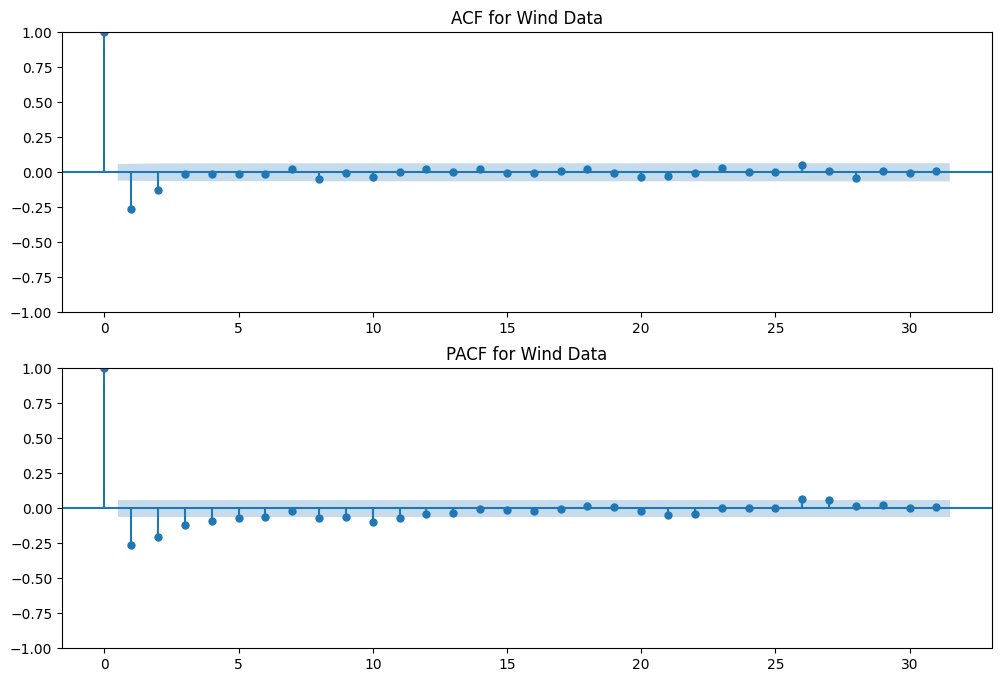

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(solar_diff, ax=ax[0], title='ACF for Wind Data')
plot_pacf(solar_diff, ax=ax[1], title='PACF for Wind Data')
plt.show()

##### Construct / Fit the **ARIMA Solar Model**

In [23]:
model_solar = ARIMA(solar_daily, order=(1, 1, 2))
solar_model_fit = model_solar.fit()

print(solar_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       Solar_Production   No. Observations:                 1096
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -10637.920
Date:                Wed, 16 Oct 2024   AIC                          21283.840
Time:                        21:47:30   BIC                          21303.834
Sample:                    01-01-2020   HQIC                         21291.406
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5598      0.076      7.360      0.000       0.411       0.709
ma.L1         -0.9425      0.085    -11.140      0.000      -1.108      -0.777
ma.L2          0.0722      0.057      1.271      0.2

##### Evaluate the **ARIMA Solar Model** on <code>Test</code> Data

In [24]:
solar_forecast = solar_model_fit.forecast(steps=len(solar_test))

rmse_solar = np.sqrt(mean_squared_error(solar_test, solar_forecast))
print(f'Solar Forecast RMSE: {rmse_solar}')

Solar Forecast RMSE: 2516.5247859849674


<div class="alert alert-block alert-danger">
<b>ARIMA/SARIMA 🚨:</b> Although initially considered, these models were found unsuitable due to high computational demands and the dataset size. Also, they fail to capture the complex and nonlinear relationships between the various factors affecting power demand.
</div>

### Second Model : ***SimpleRNN Model***

#### SimpleRNN Model for <code>***Solar***</code>

##### Data Preparation for ***RNN*** for <code>Solar</code> Model

In [25]:
scaler = MinMaxScaler()
solar_scaled = scaler.fit_transform(solar_daily)

def create_sequences(data, seq_length):

    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

* This function creates sequences for RNN input.
    1. >It takes the scaled data and a sequence length, then
    2. >generates sequences of 'seq_length' with corresponding labels.

* Parameters:
    - data (<code>np.array</code>): Scaled time series data
    - <code>seq_length</code> (int): Number of time steps to include in each sequence

* Returns:
    - X (<code>np.array</code>): Input sequences
    - y (<code>np.array</code>): Target values following each sequence

In [26]:
seq_length = 30
X, y = create_sequences(solar_scaled, seq_length)

In [27]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=30, gap=2)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Fold {fold + 1}:")
    print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
    print("_______________________________________________________________")

Fold 1:
Training data shape: X_train: (974, 30, 1), y_train: (974, 1)
Testing data shape: X_test: (30, 30, 1), y_test: (30, 1)
_______________________________________________________________
Fold 2:
Training data shape: X_train: (1004, 30, 1), y_train: (1004, 1)
Testing data shape: X_test: (30, 30, 1), y_test: (30, 1)
_______________________________________________________________
Fold 3:
Training data shape: X_train: (1034, 30, 1), y_train: (1034, 1)
Testing data shape: X_test: (30, 30, 1), y_test: (30, 1)
_______________________________________________________________


##### Construct / Fit ***RNN*** for <code>Solar</code> Model

In [28]:
model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()

/Users/almuhannad/.pyenv/versions/3.10.6/envs/renewable_energy_forecasting/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0745 - val_loss: 0.0032
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0026
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 12/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

##### Evaluation ***RNN*** for <code>Solar</code> Model

In [30]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [31]:
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

mae = mean_absolute_error(y_test_inv, y_pred_inv)

print('Test MAPE: {0:.1%}'.format(mape/100))
print(f'Test MAE: {mae}')


Test MAPE: 23.4%
Test MAE: 2362.7414660081854


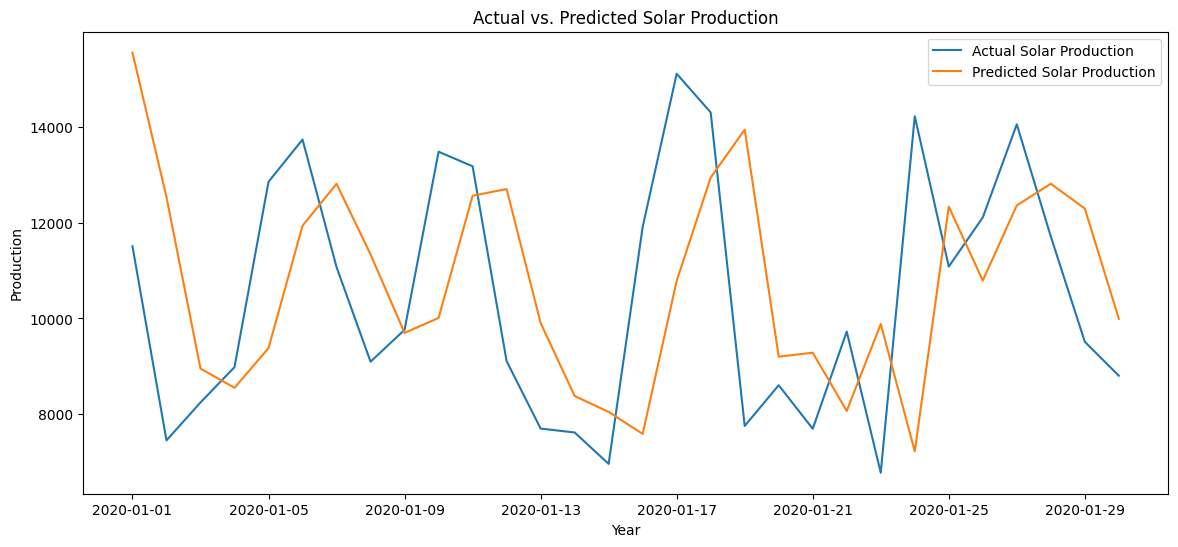

In [32]:
dates = pd.date_range(start='2020-01-01', periods=len(y_test_inv), freq='D')

plt.figure(figsize=(14, 6))
plt.plot(dates, y_test_inv, label='Actual Solar Production')
plt.plot(dates, y_pred_inv, label='Predicted Solar Production')
plt.title('Actual vs. Predicted Solar Production')
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend()
plt.show()

In [33]:
last_sequence = X_test[-1]
forecast = []

for _ in range(30):
    last_sequence_reshaped = last_sequence.reshape(1, seq_length, 1)

    next_value = model.predict(last_sequence_reshaped)

    forecast.append(next_value[0, 0])

    last_sequence = np.append(last_sequence[1:], next_value, axis=0)

forecast_inv = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

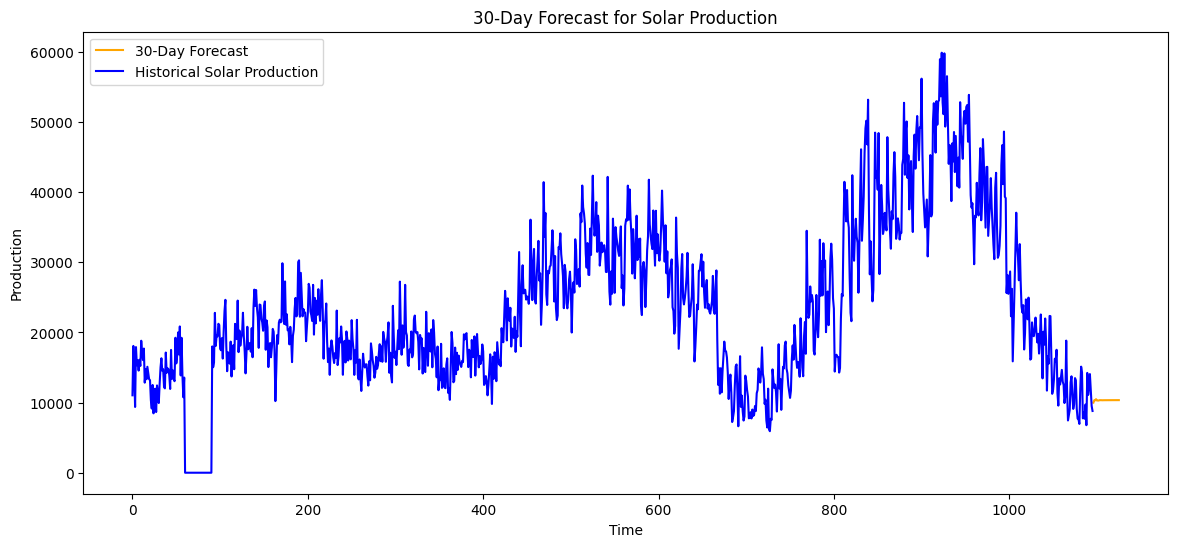

array([[ 9990.909],
       [10330.779],
       [10312.487],
       [10481.308],
       [10293.562],
       [10296.666],
       [10288.066],
       [10341.271],
       [10339.585],
       [10339.083],
       [10328.508],
       [10333.188],
       [10334.428],
       [10337.441],
       [10336.981],
       [10338.116],
       [10338.648],
       [10339.832],
       [10340.487],
       [10341.203],
       [10341.894],
       [10342.556],
       [10343.263],
       [10343.811],
       [10344.506],
       [10344.942],
       [10345.579],
       [10346.05 ],
       [10346.577],
       [10347.058]], dtype=float32)

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(solar_daily), len(solar_daily) + 30), forecast_inv, label='30-Day Forecast', color='orange')
plt.plot(range(len(solar_daily)), scaler.inverse_transform(solar_scaled), label='Historical Solar Production', color='blue')
plt.title('30-Day Forecast for Solar Production')
plt.xlabel('Time')
plt.ylabel('Production')
plt.legend()
plt.show()

forecast_inv

#### SimpleRNN Model for <code>***Wind***</code>

##### Data Preparation for ***RNN*** for <code>Wind</code> Model

In [35]:
scaler = MinMaxScaler()
wind_scaled = scaler.fit_transform(wind_daily)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [36]:
seq_length = 30
X_wind, y_wind = create_sequences(wind_scaled, seq_length)

In [37]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=30, gap=2)

for fold, (train_index, test_index) in enumerate(tscv.split(X_wind)):
    X_train, X_test = X_wind[train_index], X_wind[test_index]
    y_train, y_test = y_wind[train_index], y_wind[test_index]

    print(f"Fold {fold + 1}:")
    print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
    print("_______________________________________________________________")

Fold 1:
Training data shape: X_train: (974, 30, 1), y_train: (974, 1)
Testing data shape: X_test: (30, 30, 1), y_test: (30, 1)
_______________________________________________________________
Fold 2:
Training data shape: X_train: (1004, 30, 1), y_train: (1004, 1)
Testing data shape: X_test: (30, 30, 1), y_test: (30, 1)
_______________________________________________________________
Fold 3:
Training data shape: X_train: (1034, 30, 1), y_train: (1034, 1)
Testing data shape: X_test: (30, 30, 1), y_test: (30, 1)
_______________________________________________________________


##### Construct / Fit ***RNN*** for <code>Wind</code> Model

In [38]:
model_wind = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model_wind.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model_wind.summary()

/Users/almuhannad/.pyenv/versions/3.10.6/envs/renewable_energy_forecasting/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_wind.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0325 - val_loss: 0.0266
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0228
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - val_loss: 0.0248
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - val_loss: 0.0193
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - val_loss: 0.0190
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - val_loss: 0.0201
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0199
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0233
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0182
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0216
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0207
Epoch 12/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

##### Evaluation ***RNN*** for <code>Wind</code> Model

In [40]:
y_pred = model_wind.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [41]:
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print('Test MAPE: {0:.1%}'.format(mape/100))
print(f'Test MAE: {mae}')

Test MAPE: 23.9%
Test MAE: 33111.1513684136


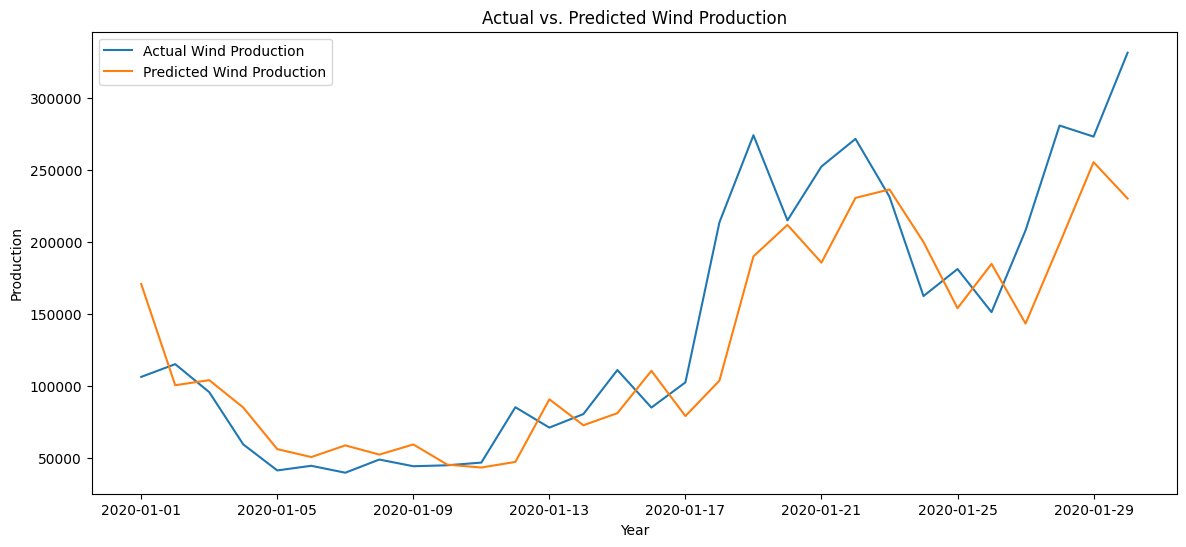

In [42]:
dates = pd.date_range(start='2020-01-01', periods=len(y_test_inv), freq='D')

plt.figure(figsize=(14, 6))
plt.plot(dates, y_test_inv, label='Actual Wind Production')
plt.plot(dates, y_pred_inv, label='Predicted Wind Production')
plt.title('Actual vs. Predicted Wind Production')
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend()
plt.show()

In [43]:
last_sequence = X_test[-1]
forecast = []

for _ in range(30):
    last_sequence_reshaped = last_sequence.reshape(1, seq_length, 1)

    next_value = model.predict(last_sequence_reshaped)

    forecast.append(next_value[0, 0])

    last_sequence = np.append(last_sequence[1:], next_value, axis=0)

forecast_inv = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms

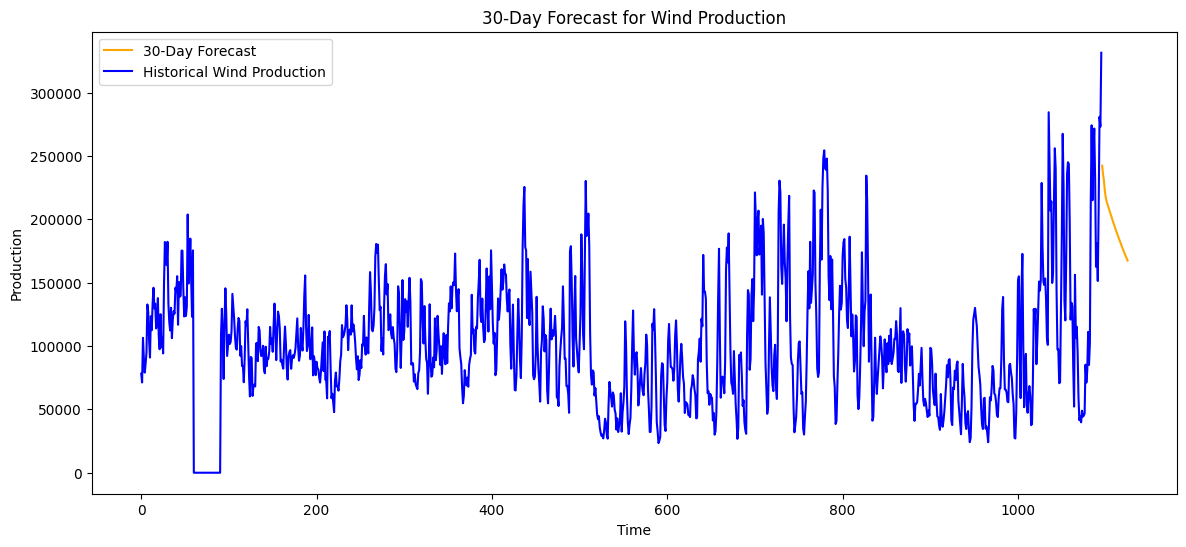

array([[242228.81],
       [235454.8 ],
       [230504.14],
       [222843.36],
       [217697.62],
       [214359.52],
       [211971.44],
       [209804.83],
       [207613.94],
       [205360.08],
       [203266.92],
       [201128.7 ],
       [198982.22],
       [196883.81],
       [194815.84],
       [192790.19],
       [190794.2 ],
       [188830.36],
       [186896.23],
       [184986.9 ],
       [183101.38],
       [181245.94],
       [179417.28],
       [177614.38],
       [175842.47],
       [174101.33],
       [172387.25],
       [170701.83],
       [169040.25],
       [167399.25]], dtype=float32)

In [44]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(wind_daily), len(wind_daily) + 30), forecast_inv, label='30-Day Forecast', color='orange')
plt.plot(range(len(wind_daily)), scaler.inverse_transform(wind_scaled), label='Historical Wind Production', color='blue')
plt.title('30-Day Forecast for Wind Production')
plt.xlabel('Time')
plt.ylabel('Production')
plt.legend()
plt.show()

forecast_inv